In [ ]:
# Cell 1: Parameters & imports / Parámetros e imports
import pandas as pd, numpy as np, geopandas as gpd
import os, sys, re, glob, yaml
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from scipy.stats import spearmanr
from sqlalchemy import create_engine

ROOT = Path.cwd()
while ROOT != ROOT.parent and not (ROOT/"config.yml").exists() and not (ROOT/".git").exists():
      ROOT = ROOT.parent
if str(ROOT) not in sys.path: sys.path.insert(0, str(ROOT))
cfg = yaml.safe_load((ROOT/"config.yml").read_text()) if (ROOT/"config.yml").exists() else {}
RAW_DIR   = ROOT / cfg.get("data", {}).get("raw_dir", "data/raw")
PROC = ROOT/ cfg.get("data",{}).get("processed_dir","data/processed")
ADOPTION_DEFAULT = cfg.get("defaults", {}).get("adoption_rate_default", 0.30)
PRIORITY         = cfg.get("defaults", {}).get("priority_districts", [10,11,12,13,15])
madrid_codes_official = set(cfg.get("defaults", {}).get("madrid_postal_codes_official", []))
print(f"RAW={RAW_DIR} \nPROC={PROC} ")  # summary / resumen

RAW=c:\_Workspace\2_Work\1_Projects_Active\Datos_Abiertos_Madrid\Low-Carbon-Heating-Roadmap-for-Madrid\data\raw 
PROC=c:\_Workspace\2_Work\1_Projects_Active\Datos_Abiertos_Madrid\Low-Carbon-Heating-Roadmap-for-Madrid\data\processed 


In [ ]:
# Cell 2: Load processed data / Cargar datos procesados
from src.loader import (
    read_local,                    # carga local / local load
    load_heating_specs,            # tecnologías calefacción / heating tech specs
    load_avg_income,               # renta media distritos madrid / average income in madrid per district
    load_stakeholder_map,          # mapa actores clave / stakeholder map
    load_air_realtime,        # mapa de calidad del aire tiempo real / real time air quality 
)
# Load datasets / Cargar datasets
income       = load_avg_income(save=False)
stakeholders = load_stakeholder_map(save=False)
tech_specs   = load_heating_specs (save=False)
df_ceee = pd.read_csv(PROC/"df_ceee.csv")
df_gei = pd.read_csv(PROC/"df_gei.csv")
df_pst = pd.read_csv(PROC/"df_pst.csv")
air = load_air_realtime(save=False)
# Load shapefile directly with geopandas / Cargar shapefile directamente con geopandas
districts = gpd.read_file(RAW_DIR / "Distritos" / "DISTRITOS.shp")
# Print summary shapes / Imprimir resumen de formas
print("df_gei:", df_gei.shape, "df_ceee:", df_ceee.shape, "df_pst:", df_pst.shape, "avg_income:", income.shape, "tech_specs:", tech_specs.shape, "stakeholders:", stakeholders.shape, "districts:", districts.shape, "air:", air.shape)

df_gei: (5885, 5) df_ceee: (50638, 6) df_pst: (264, 3) avg_income: (54, 2) tech_specs: (4, 7) stakeholders: (6, 5) districts: (21, 12) air: (126, 56)


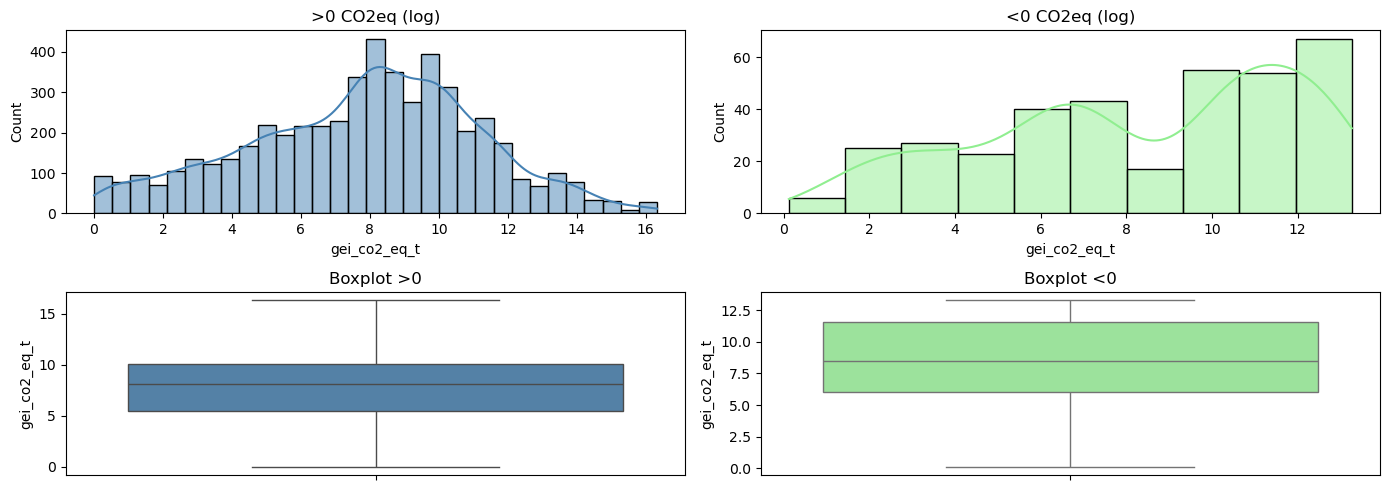

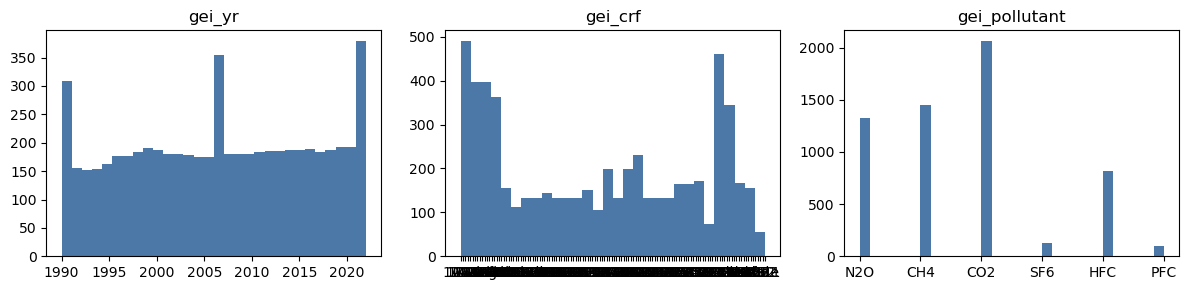

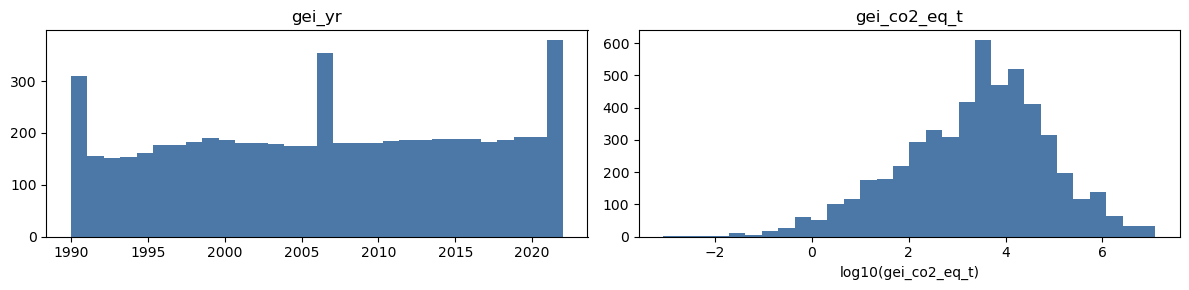

Totals by sector / Totales por sector:
 sector_group
Energy         6.512636e+08
Waste          6.306777e+07
Industry       6.243648e+07
Land Uses     -2.446264e+07
Agriculture    9.535677e+06
Name: gei_co2_eq_t, dtype: float64


C:\Users\LAP-MPC\AppData\Local\Temp\ipykernel_3660\3296279227.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.xlabel(""); plt.legend().remove(); plt.tight_layout(); plt.show()


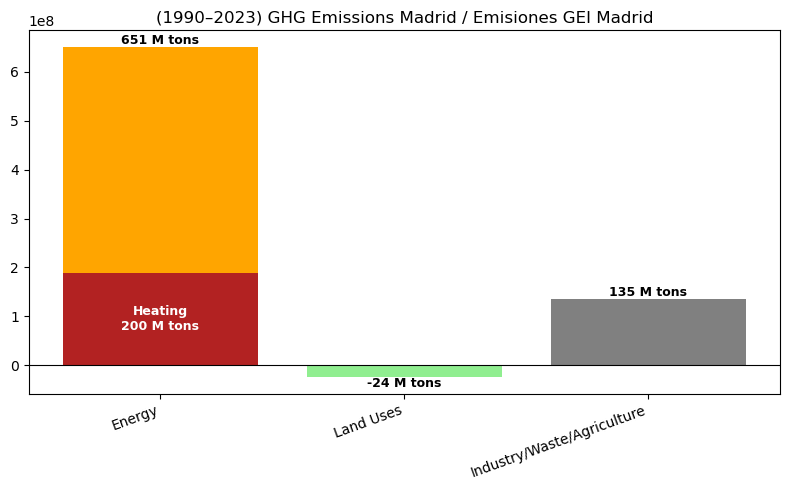

Correlation test / Test de correlación
H0: Heating and total emissions are uncorrelated
H1: Heating and total emissions are positively correlated
Pearson r = 0.91, p = 2.84e-13

One-sample t-test / Test t de una muestra
Why: We test if the mean heating share is significantly greater than 20%.
H0: Mean heating share = 20%
H1: Mean heating share > 20%
T = 15.86, one-sided p = 5.17e-17, observed mean = 24.9%

Bootstrap confidence interval / Intervalo de confianza bootstrap
Why: The bootstrap resamples the data many times to estimate the distribution of the mean share.
This avoids relying only on normality assumptions of the t-test.
95% CI for mean heating share: 24.3% – 25.5%


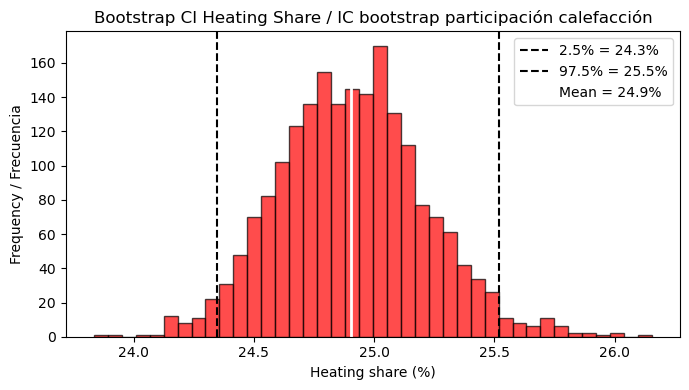

In [ ]:
# Cell 3: GHG Madrid 1990–2023 EDA / GEI Madrid 1990–2023

import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats

# --- Split & log-transform / Dividir y log-transformar ---
pos, neg = df_gei.loc[df_gei["gei_co2_eq_t"]>0,"gei_co2_eq_t"], df_gei.loc[df_gei["gei_co2_eq_t"]<0,"gei_co2_eq_t"]
pos_log, neg_log = np.log1p(pos), np.log1p(-neg)

# --- Histograms & boxplots / Histogramas y cajas ---
fig,ax=plt.subplots(2,2,figsize=(14,5))
sns.histplot(pos_log,kde=True,color="steelblue",ax=ax[0,0]); ax[0,0].set(title=">0 CO2eq (log)")
sns.histplot(neg_log,kde=True,color="lightgreen",ax=ax[0,1]); ax[0,1].set(title="<0 CO2eq (log)")
sns.boxplot(y=pos_log,color="steelblue",ax=ax[1,0]); ax[1,0].set(title="Boxplot >0")
sns.boxplot(y=neg_log,color="lightgreen",ax=ax[1,1]); ax[1,1].set(title="Boxplot <0")
plt.tight_layout(); plt.show()

# --- Univariate & log tails / Univariante y colas log ---
for cols in [["gei_yr","gei_crf","gei_pollutant"],["gei_yr","gei_co2_eq_t"]]:
    fig,axs=plt.subplots(1,len(cols),figsize=(12,3))
    for ax,c in zip(axs,cols):
        x=df_gei[c].replace([np.inf,-np.inf],np.nan).dropna()
        if c=="gei_co2_eq_t": x=x[x>0]; x=np.log10(x); ax.set_xlabel(f"log10({c})")
        ax.hist(x,bins=30,color="#4c78a8"); ax.set_title(c)
    plt.tight_layout(); plt.show()

# --- Sector collapse / Agrupar sectores ---
crf_map={"1":"Energy","2":"Industry","3":"Agriculture","4":"Land Uses","5":"Waste","6":"Other"}
df_gei["sector_group"]=df_gei["gei_crf"].str[0].map(crf_map).fillna("Other")
summary=df_gei.groupby("sector_group")["gei_co2_eq_t"].sum().sort_values(key=lambda s:s.abs(),ascending=False)
print("Totals by sector / Totales por sector:\n",summary)

# --- Heating stacked bar chart / Barra apilada de calefacción ---
heating_crfs=["1A1a","1A4a","1A4b","1A4c"]
df_gei["is_heating"]=df_gei["gei_crf"].isin(heating_crfs)

def collapse_group(sector):
    if sector=="Energy": return "Energy"
    elif sector=="Land Uses": return "Land Uses"
    elif sector in ["Industry","Waste","Agriculture"]: return "Industry/Waste/Agriculture"
    else: return "Other"

df_gei["group3"]=df_gei["sector_group"].map(collapse_group)
summary3=df_gei.groupby("group3")["gei_co2_eq_t"].sum()
energy_total, heating_total = summary3["Energy"], df_gei[df_gei["is_heating"]]["gei_co2_eq_t"].sum()
other_energy=energy_total-heating_total

bars={"Energy":(heating_total,other_energy),
      "Land Uses":(summary3["Land Uses"],),
      "Industry/Waste/Agriculture":(summary3["Industry/Waste/Agriculture"],)}

plt.figure(figsize=(12,5))
plt.bar("Energy",bars["Energy"][0],color="firebrick")
plt.bar("Energy",bars["Energy"][1],bottom=bars["Energy"][0],color="orange")
plt.bar("Land Uses",bars["Land Uses"][0],color="lightgreen")
plt.bar("Industry/Waste/Agriculture",bars["Industry/Waste/Agriculture"][0],color="gray")
plt.axhline(0,color="black",lw=0.8)
plt.text(0,bars["Energy"][0]/2,"Heating\n200 M tons",ha="center",va="center",color="white",fontsize=9,fontweight="bold")
totals={"Energy":round(energy_total/1e6),
        "Land Uses":round(summary3["Land Uses"]/1e6),
        "Industry/Waste/Agriculture":round(summary3["Industry/Waste/Agriculture"]/1e6)}
for i,(grp,val) in enumerate(totals.items()):
    label=f"{val} M tons"
    plt.text(i,summary3[grp],label,ha="center",va="bottom" if val>=0 else "top",fontsize=9,fontweight="bold")
plt.xticks(rotation=20,ha="right")
plt.title("(1990–2023) GHG Emissions Madrid / Emisiones GEI Madrid")
plt.xlabel(""); plt.legend().remove(); plt.tight_layout(); plt.show()

# --- Hypothesis tests & CI / Tests de hipótesis e IC ---
totals  = df_gei.groupby("gei_yr")["gei_co2_eq_t"].sum()
heating = df_gei[df_gei.is_heating].groupby("gei_yr")["gei_co2_eq_t"].sum()
share   = heating / totals

# --- Correlation / Correlación ---
r, p = stats.pearsonr(heating.reindex(totals.index, fill_value=0), totals)
print("Correlation test / Test de correlación")
print("H0: Heating and total emissions are uncorrelated")
print("H1: Heating and total emissions are positively correlated")
print(f"Pearson r = {r:.2f}, p = {p:.3g}\n")

# --- One-sample t-test / Test t de una muestra ---
t, p = stats.ttest_1samp(share.dropna(), 0.2)
print("One-sample t-test / Test t de una muestra")
print("Why: We test if the mean heating share is significantly greater than 20%.\n"
      "H0: Mean heating share = 20%\n"
      "H1: Mean heating share > 20%")
print(f"T = {t:.2f}, one-sided p = {p/2:.3g}, observed mean = {share.mean()*100:.1f}%\n")

# --- Bootstrap CI / IC bootstrap ---
boot = [share.sample(frac=1, replace=True).mean() for _ in range(2000)]
ci   = np.percentile(boot, [2.5, 97.5])
print("Bootstrap confidence interval / Intervalo de confianza bootstrap")
print("Why: The bootstrap resamples the data many times to estimate the distribution of the mean share.\n"
      "This avoids relying only on normality assumptions of the t-test.")
print(f"95% CI for mean heating share: {ci[0]*100:.1f}% – {ci[1]*100:.1f}%")

# --- Plot bootstrap distribution / Graficar distribución bootstrap ---
plt.figure(figsize=(7,4))
plt.hist([s*100 for s in boot], bins=40, color="red", edgecolor="k", alpha=0.7)
plt.axvline(ci[0]*100, color="black", ls="--", label=f"2.5% = {ci[0]*100:.1f}%")
plt.axvline(ci[1]*100, color="black", ls="--", label=f"97.5% = {ci[1]*100:.1f}%")
plt.axvline(share.mean()*100, color="white", lw=2, label=f"Mean = {share.mean()*100:.1f}%")
plt.title("Bootstrap CI Heating Share / IC bootstrap participación calefacción")
plt.xlabel("Heating share (%)"); plt.ylabel("Frequency / Frecuencia")
plt.legend(); plt.tight_layout(); plt.show()

| Concept                  | Explanation                                                                 | Explicación                                                          |
|--------------------------|--------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------|
| CO₂eq (CO₂ equivalent)   | Combines all greenhouse gases (methane, nitrous oxide, etc) into one value based on their global warming potential (GWP). | Combina todos los gases de efecto invernadero en un solo valor según su potencial de calentamiento global (GWP). |
| Why use CO₂eq?           | To compare gases like methane or nitrous oxide as if they were CO₂.                 | Para comparar gases como metano o óxidos de nitrógeno como si fueran CO₂.             |
| Example                  | 1 ton of methane ≈ 25 tons of CO₂eq.                                                | 1 tonelada de metano ≈ 25 toneladas de CO₂eq.                                         |
| Negative CO₂eq values    | Indicate net carbon removal (e.g. forests absorbing more CO₂ than they emit).       | Indican remoción neta de carbono (ej. bosques absorbiendo más CO₂ del que emiten).   |
| Where negatives appear   | Common in land use, forestry, or carbon offset sectors.                             | Común en sectores de uso del suelo, silvicultura o compensaciones de carbono.         |
| What to check            | Lets look at sector_crf or category_crf to understand the source of negative values.     | Revisar sector_crf o category_crf para entender el origen de los valores negativos.    |

| Group              | Description                                   | Descripción                                   | CO₂eq [tons]    |
|--------------------|-----------------------------------------------|-----------------------------------------------|---------------|
| Energy             | Combustion, leaks                             | Combustión, fugas                             | 651.263.619,91 t   |
| Industry           | F-gases, minerals, metals, solvents           | Gases fluorados, minerales, metales, disolventes | 62.436.475,74 t     |
| Agriculture        | Livestock, soils, manure, rice, burning       | Ganado, suelos, estiércol, arroz, quema       | 9,535.677,39 t      |
| Waste              | Landfills, wastewater, incineration           | Vertederos, aguas residuales, incineración    | 63.067.766,90 t     |
| Land Uses (LULUCF) | Forests, cropland, grassland, wetlands, wood products | Bosques, cultivos, pastizales, humedales, madera | -24.462.637,14 t    |

##  Energy CO₂eq vs Total — Interpretation / Interpretación

| Año clave | Explanation                                                              | Explicación                                                                |
|-----------|----------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| 2007–2008 | Total emissions peak, then begin gradual decline. Energy emissions follow but lag.    | Las emisiones totales alcanzan su punto máximo y luego comienzan a descender. Energía sigue, pero con retraso. |
| 2019      | Energy emissions drop sharply, diverging from previous trend.                         | Las emisiones de energía caen bruscamente, rompiendo la tendencia anterior.             |
| 2020      | COVID-19 lockdowns reduce mobility, industrial activity, and heating demand.          | Los confinamientos por COVID-19 reducen movilidad, actividad industrial y demanda de calefacción. |
| Post-2020 | Signals a structural shift: remote work, energy efficiency, and decarbonization gain traction. | Señala un cambio estructural: teletrabajo, eficiencia energética y descarbonización ganan impulso. |

---

###  Stakeholder Implications / Implicaciones para actores clave

| Sector / Stakeholder       | English Impact Summary                                                  | Resumen de impacto en español                                                  |
|----------------------------|--------------------------------------------------------------------------|---------------------------------------------------------------------------------|
| Government / Gobierno      | Policy momentum shifts toward green recovery and climate targets.       | El impulso político se orienta hacia recuperación verde y metas climáticas.    |
| Industry / Industria       | Pressure to decarbonize operations, electrify heating, and report GEI.  | Presión para descarbonizar, electrificar calefacción y reportar GEI.           |
| Investors / Inversores     | Funding flows into renewables, building retrofits, and low-carbon tech. | Flujos de inversión hacia renovables, rehabilitación y tecnología baja en carbono. |
| Citizens / Ciudadanía      | Behavioral shifts (remote work, energy use) become part of climate action. | Cambios de comportamiento (teletrabajo, uso energético) se integran en la acción climática. |

---
##  Statistical Test Results / Resultados de Pruebas Estadísticas

- **Correlation / Correlación**
  - H₀: Heating and total emissions are uncorrelated  
  - H₁: Heating and total emissions are positively correlated  
  - Result: r = 0.91, p = 2.84e-13 → **Strong positive correlation**  
  - Resultado: r = 0.91, p = 2.84e-13 → **Correlación positiva fuerte**

- **One-sample t-test / Test t de una muestra**
  - H₀: Mean heating share = 20%  
  - H₁: Mean heating share > 20%  
  - Result: t = 15.86, one-sided p = 5.17e-17, mean ≈ 25%  
  - Resultado: t = 15.86, p unilateral = 5.17e-17, media ≈ 25%  
  - Interpretation / Interpretación: Heating share is **significantly above 20%**

- **Bootstrap 95% CI / IC bootstrap al 95%**
  - Interval: 24.3% – 25.5%  
  - Intervalo: 24.3% – 25.5%  
  - Interpretation / Interpretación: Heating consistently represents about **one quarter of total emissions**

###  What This Chart Means / Qué significa este gráfico

- **The 2020 drop is not just noise** — it reflects a real disruption in energy-related emissions.
- **Post-COVID recovery opens a window** for structural changes in heating, transport, and building efficiency.
- **Stakeholders** The rise in Spain after 1990 reflects urbanization, increased mobility, expanded energy demand in buildings, and a shift toward fossil-based heating — even as housing construction slowed in recent years. The sharp drop around 2020 is almost certainly COVID: lockdowns, reduced transport, lower industrial output, and less heating in offices. That drop is a signal — not just of disruption, but of opportunity. It shows how fast emissions can fall when systems pause. For policymakers and stakeholders, it’s proof that structural change is possible. It opens the door to funding retrofits, electrifying heating, and accelerating decarbonization.

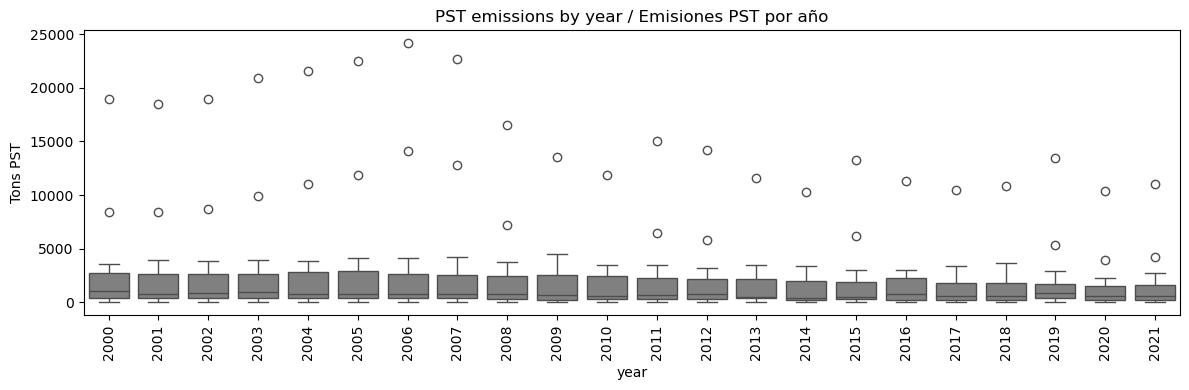

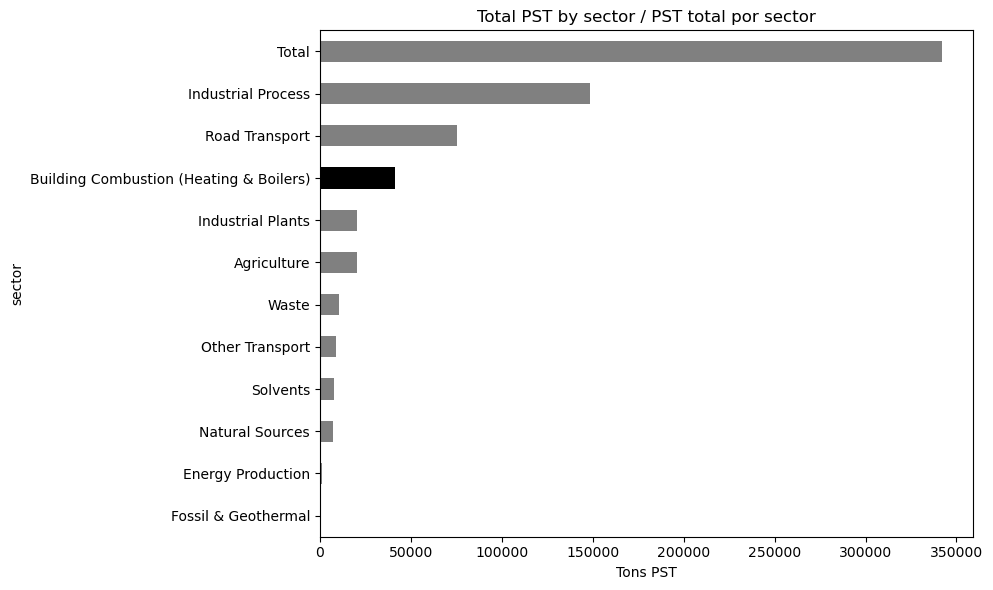

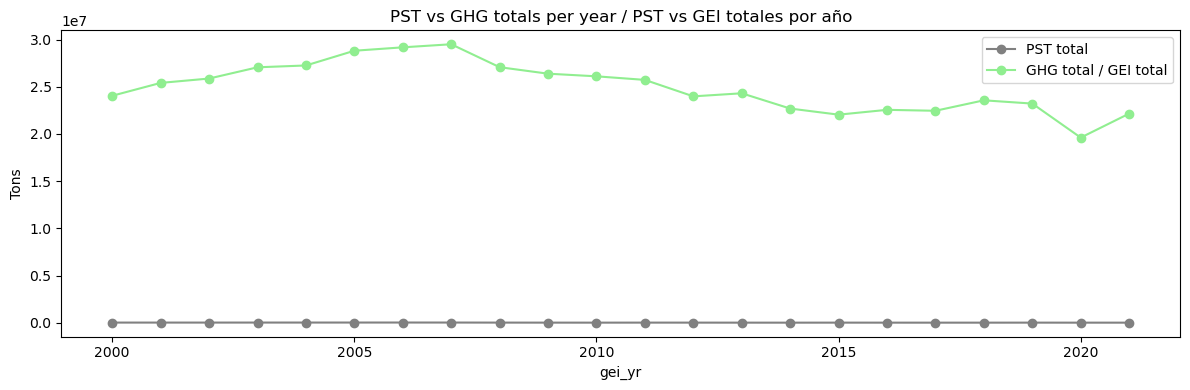

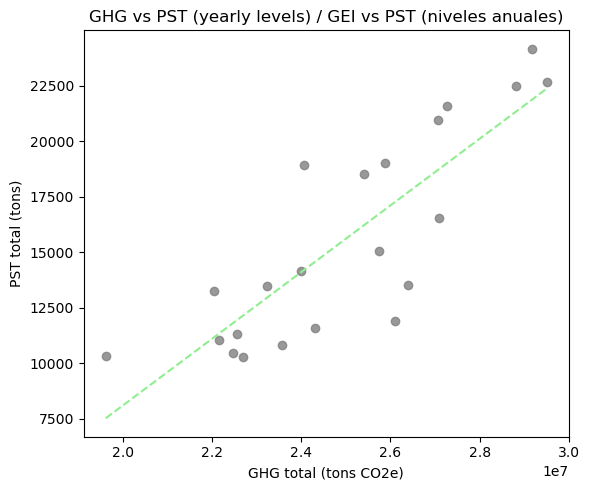

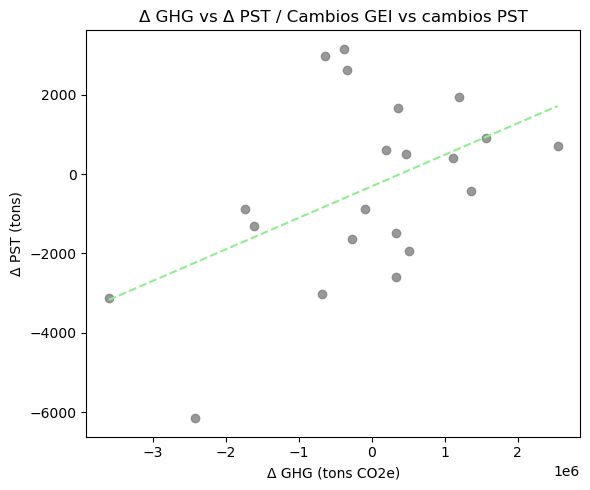

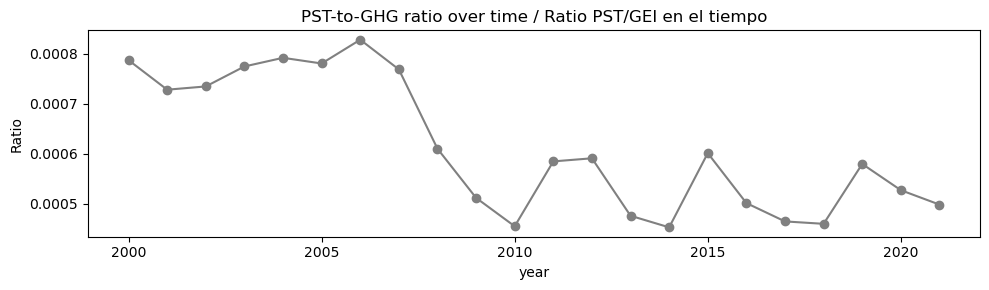

Correlation test (levels) / Test de correlación (niveles)
H0: No correlation / Sin correlación
H1: Positive correlation / Correlación positiva
Pearson r = 0.84, p = 1.33e-06

Correlation test (Δ-year) / Test de correlación (Δ anual)
H0: No correlation in changes / Sin correlación en cambios
H1: Positive correlation in changes / Correlación positiva en cambios
Pearson r = 0.49, p = 0.0255

One-sample t-test on PST/GHG ratio / Test t de una muestra sobre ratio PST/GEI
H0: Mean ratio = 5.0%  |  H1: Mean ratio > 5.0%
T = -1734.87, one-sided p = 6.21e-56, mean = 0.06%

95% CI for mean PST/GHG ratio: 0.06% – 0.07%


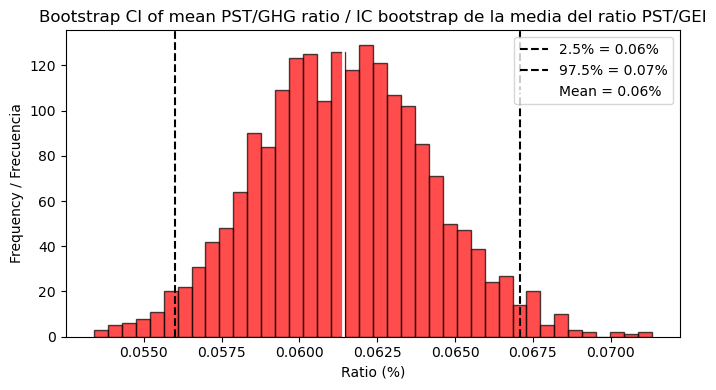

In [ ]:
# Cell 5: PST EDA + GEI comparison  / EDA PST + comparación GEI 

# --- Map PST concepts to clear sectors / Mapear conceptos PST a sectores claros ---
map_dict = {
    "Total emisión de partículas en suspensión": "Total",
    "Emisión de partículas en suspensión en procesos industriales en combustión": "Industrial Combustion",
    "Emisión de partículas en suspensión en procesos industriales sin combustión": "Industrial Process",
    "Emisión de partículas en suspensión en el transporte por carretera": "Road Transport",
    "Emisión de partículas en suspensión en plantas de combustión no industrial": "Building Combustion (Heating & Boilers)",
    "Emisión de partículas en suspensión en plantas de combustión industrial": "Industrial Plants",
    "Emisión de partículas en suspensión en el uso de disolventes y otros productos": "Solvents",
    "Emisión de partículas en suspensión en la agricultura y silvicultura": "Agriculture",
    "Emisión de partículas en suspensión en agricultura": "Agriculture",
    "Emisión de partículas en suspensión en tratamiento de aguas residuales y residuos": "Waste",
    "Emisión de partículas en suspensión en el tratamiento y eliminación de residuos": "Waste",
    "Emisión de partículas en suspensión en el uso de productos fluorados": "Fluorinated",
    "Emisión de partículas en suspensión en la extracción y distribución de combustibles fósiles y energía geotérmica": "Fossil & Geothermal",
    "Emisión de partículas en suspensión en otras fuentes": "Other",
    "Emisión de partículas en suspensión en otras fuentes y sumideros (naturaleza)": "Natural Sources",
    "Emisión de partículas en suspensión en la combustión en la producción y transformación de energía": "Energy Production",
    "Emisión de partículas en suspensión en otros modos de transporte y maquinaria móvil": "Other Transport"
}
df_pst["sector"] = df_pst["emission_concept"].map(map_dict).fillna(df_pst["emission_concept"])

# ======================
# EDA battery / Bloque EDA
# ======================

# 1) PST distribution by year (grey) / Distribución PST por año (gris)
plt.figure(figsize=(12,4))
sns.boxplot(x="year", y="tons_pst", data=df_pst, color="grey")
plt.xticks(rotation=90); plt.title("PST emissions by year / Emisiones PST por año"); plt.ylabel("Tons PST")
plt.tight_layout(); plt.show()

# 2) PST totals by sector (grey, highlight Building Combustion in black) / Totales por sector
totals_pst = df_pst.groupby("sector")["tons_pst"].sum().sort_values()
colors = ["black" if s=="Building Combustion (Heating & Boilers)" else "grey" for s in totals_pst.index]
plt.figure(figsize=(10,6)); totals_pst.plot.barh(color=colors)
plt.title("Total PST by sector / PST total por sector"); plt.xlabel("Tons PST")
plt.tight_layout(); plt.show()

# 3) Time series: PST total (grey) vs GEI total (light green) / Series temporales
pst_total_year = df_pst[df_pst["sector"]!="Total"].groupby("year")["tons_pst"].sum()
gei_total_year = df_gei.groupby("gei_yr")["gei_co2_eq_t"].sum()
years = sorted(set(pst_total_year.index).intersection(set(gei_total_year.index)))
pst_y = pst_total_year.reindex(years).astype(float)
gei_y = gei_total_year.reindex(years).astype(float)

plt.figure(figsize=(12,4))
pst_y.plot(marker="o", color="grey", label="PST total")
gei_y.plot(marker="o", color="lightgreen", label="GHG total / GEI total")
plt.title("PST vs GHG totals per year / PST vs GEI totales por año"); plt.ylabel("Tons")
plt.legend(); plt.tight_layout(); plt.show()

# 4) Scatter with regression: GHG vs PST (levels) / Dispersión con regresión: GEI vs PST (niveles)
plt.figure(figsize=(6,5))
plt.scatter(gei_y, pst_y, color="grey", alpha=0.8)
m,b = np.polyfit(gei_y, pst_y, 1); x_line = np.linspace(gei_y.min(), gei_y.max(), 50)
plt.plot(x_line, m*x_line+b, color="lightgreen", linestyle="--")
plt.title("GHG vs PST (yearly levels) / GEI vs PST (niveles anuales)")
plt.xlabel("GHG total (tons CO2e)"); plt.ylabel("PST total (tons)")
plt.tight_layout(); plt.show()

# 5) Δ-year coupling: GHG vs PST changes / Acoplamiento interanual: cambios GEI vs PST
dx, dy = gei_y.diff().dropna(), pst_y.diff().dropna()
plt.figure(figsize=(6,5))
plt.scatter(dx, dy, color="grey", alpha=0.8)
m2,b2 = np.polyfit(dx, dy, 1); x_line2 = np.linspace(dx.min(), dx.max(), 50)
plt.plot(x_line2, m2*x_line2+b2, color="lightgreen", linestyle="--")
plt.title("Δ GHG vs Δ PST / Cambios GEI vs cambios PST")
plt.xlabel("Δ GHG (tons CO2e)"); plt.ylabel("Δ PST (tons)")
plt.tight_layout(); plt.show()

# 6) Ratio PST/GHG over time (grey line) / Ratio PST/GEI en el tiempo (línea gris)
ratio = (pst_y / gei_y.replace(0, np.nan)).dropna()
plt.figure(figsize=(10,3))
ratio.plot(marker="o", color="grey")
plt.title("PST-to-GHG ratio over time / Ratio PST/GEI en el tiempo"); plt.ylabel("Ratio")
plt.tight_layout(); plt.show()

# ======================
# Hypotheses & CI / Hipótesis e IC
# ======================

# H1a: PST and GHG totals are positively correlated (levels) / Correlación positiva (niveles)
r_levels, p_levels = stats.pearsonr(gei_y, pst_y)
print("Correlation test (levels) / Test de correlación (niveles)")
print("H0: No correlation / Sin correlación")
print("H1: Positive correlation / Correlación positiva")
print(f"Pearson r = {r_levels:.2f}, p = {p_levels:.3g}\n")

# H1b: Year-to-year changes are correlated / Correlación en cambios interanuales
if len(dx)==len(dy) and len(dx)>2:
    r_delta, p_delta = stats.pearsonr(dx, dy)
    print("Correlation test (Δ-year) / Test de correlación (Δ anual)")
    print("H0: No correlation in changes / Sin correlación en cambios")
    print("H1: Positive correlation in changes / Correlación positiva en cambios")
    print(f"Pearson r = {r_delta:.2f}, p = {p_delta:.3g}\n")

# H1c: Mean PST/GHG ratio exceeds a threshold (e.g., 5%) / La media del ratio PST/GEI supera un umbral (p.ej., 5%)
thr = 0.05
t_stat, p_val = stats.ttest_1samp(ratio, thr)
print("One-sample t-test on PST/GHG ratio / Test t de una muestra sobre ratio PST/GEI")
print(f"H0: Mean ratio = {thr*100:.1f}%  |  H1: Mean ratio > {thr*100:.1f}%")
print(f"T = {t_stat:.2f}, one-sided p = {p_val/2:.3g}, mean = {ratio.mean()*100:.2f}%\n")

# Bootstrap CI for mean PST/GHG ratio / IC bootstrap para la media del ratio PST/GEI
boot = [ratio.sample(frac=1, replace=True).mean() for _ in range(2000)]
ci = np.percentile(boot, [2.5, 97.5])
print(f"95% CI for mean PST/GHG ratio: {ci[0]*100:.2f}% – {ci[1]*100:.2f}%")

plt.figure(figsize=(7,4))
plt.hist([s*100 for s in boot], bins=40, color="red", edgecolor="k", alpha=0.7)
plt.axvline(ci[0]*100, color="black", ls="--", label=f"2.5% = {ci[0]*100:.2f}%")
plt.axvline(ci[1]*100, color="black", ls="--", label=f"97.5% = {ci[1]*100:.2f}%")
plt.axvline(ratio.mean()*100, color="white", lw=2, label=f"Mean = {ratio.mean()*100:.2f}%")
plt.title("Bootstrap CI of mean PST/GHG ratio / IC bootstrap de la media del ratio PST/GEI")
plt.xlabel("Ratio (%)"); plt.ylabel("Frequency / Frecuencia")
plt.legend(); plt.tight_layout(); plt.show()

| Aspect / Aspecto        | English Summary                                                                 | Resumen en Español                                                                 |
|--------------------------|---------------------------------------------------------------------------------|------------------------------------------------------------------------------------|
| Yearly Boxplot           | Shows PST emissions fluctuating 2000–2021 with visible outliers. Indicates episodic spikes tied to heating demand or industrial activity. | Muestra fluctuaciones de emisiones PST entre 2000–2021 con picos atípicos. Refleja eventos puntuales ligados a la demanda de calefacción o actividad industrial. |
| Sector Bar Chart         | Highlights Non-Industrial Combustion (heating), Road Transport, and Industrial Combustion as dominant sources. Overlaps with energy CO₂eq emissions in df_gei. | Evidencia que la combustión no industrial (calefacción), el transporte por carretera y la combustión industrial son las principales fuentes. Coinciden con sectores que generan CO₂eq en df_gei. |
| Policy Relevance         | Heating is a dual-problem sector: reducing heating emissions lowers both CO₂eq (climate) and PST (air quality/health). | La calefacción es un sector crítico: reducir sus emisiones disminuye tanto CO₂eq (clima) como PST (salud y calidad del aire). |
| Stakeholder – Municipalities | Justify heating retrofits as climate + health policy. | Justificar programas de rehabilitación energética como política climática y sanitaria. |
| Stakeholder – Investors  | Double ROI: emissions reduction + public health benefit. | Retorno doble: reducción de emisiones + beneficio sanitario. |
| Stakeholder – Citizens   | Cleaner winter air, fewer respiratory issues. | Aire más limpio en invierno, menos problemas respiratorios. |
| Stakeholder – EU/Regulators | Compliance with climate and air quality directives. | Cumplimiento de directivas de clima y calidad del aire. |

N rows: 50638
                             count     mean       std    min       50%  \
e_surface_m2               50638.0  336.551  1542.760   9.60    79.800   
e_pct_surface_heated       50638.0  966.466   121.593  10.00  1000.000   
e_heating_demand_kwh_m2_a  50638.0  110.589    49.910   0.08   106.230   
final_heating_kwh_m2_a     50638.0  125.287    70.925   0.01   118.720   
nonren_heating_kwh_m2_a    50638.0  167.049    92.075   0.01   156.285   
postal_code_idx            50638.0   26.889    14.233   1.00    27.000   

                                max  
e_surface_m2               77745.40  
e_pct_surface_heated        1010.00  
e_heating_demand_kwh_m2_a   1505.00  
final_heating_kwh_m2_a      2862.25  
nonren_heating_kwh_m2_a     5592.84  
postal_code_idx               55.00  


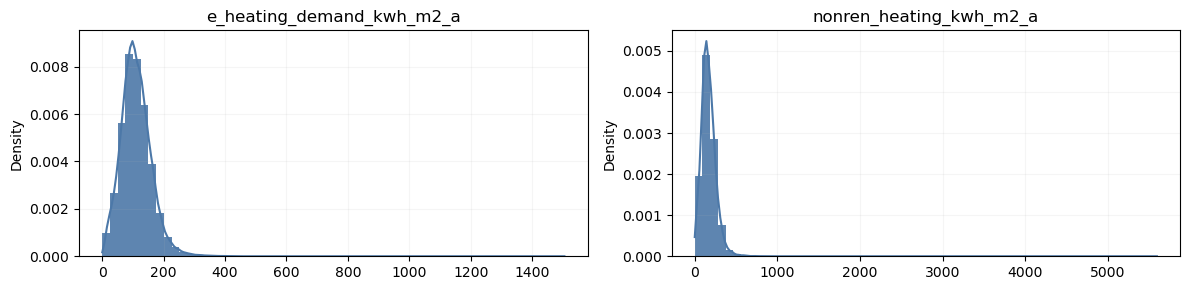

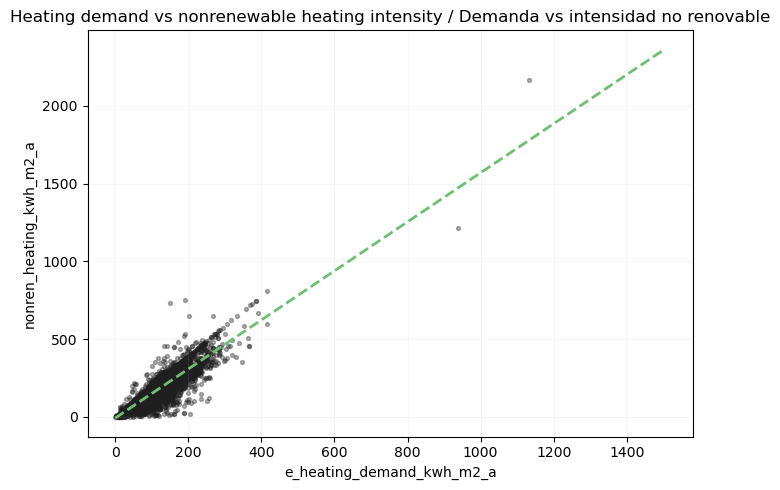

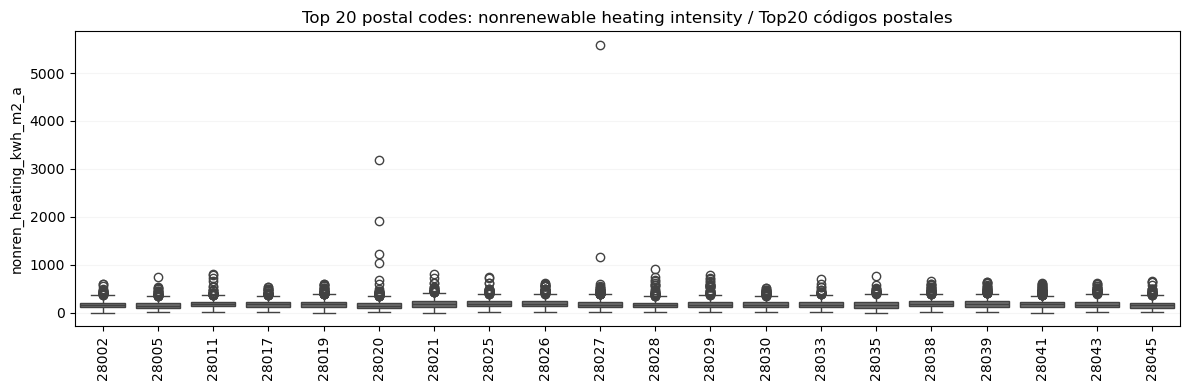

Aggregated sample (first 8 postal_code indices):
                  e_surface_m2  mean_heating_demand  mean_nonren_intensity
postal_code_idx                                                          
1                      310.84                99.65                 143.48
2                      348.99               107.83                 161.90
3                      339.13               101.10                 151.60
4                      176.67                95.79                 140.34
5                      257.42               103.67                 157.53
6                      693.48               104.75                 155.38
7                      281.72                97.05                 142.70
8                      337.15               106.15                 158.05


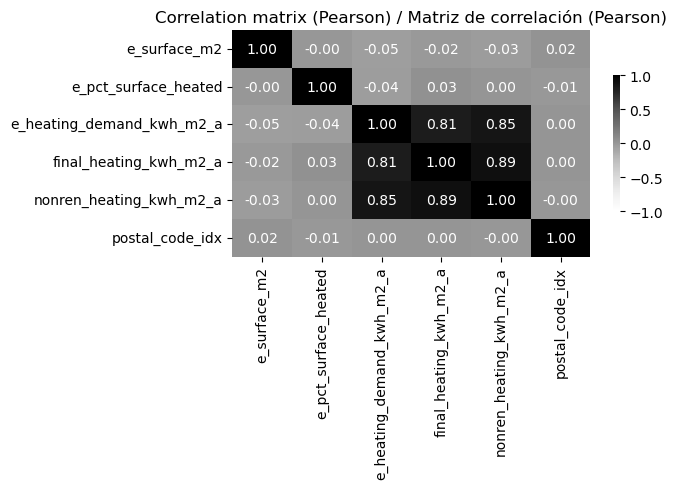


Observed Pearson r (demand vs nonren) = 0.855, 95% bootstrap CI = [-0.008, 0.009]

Hypothesis: H0 r=0 vs H1 r>0
Pearson r = 0.855, two-sided p = 0, one-sided p = 0

Kruskal-Wallis (top postcodes): H = 518.101, p = 8.86e-98


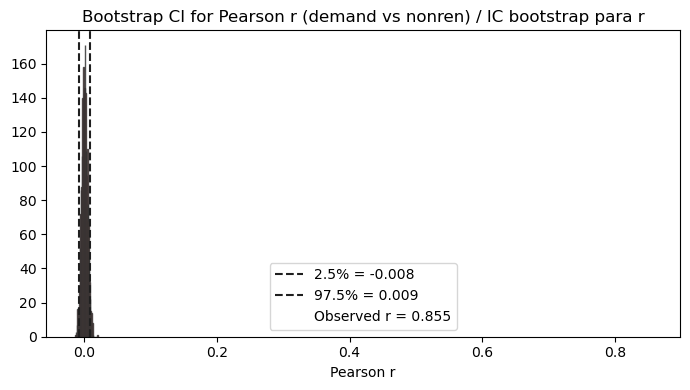


Interpretation / Interpretación:
- Observed r = 0.855 suggests positive linear association between heating demand and nonrenewable intensity.
- Bootstrap 95% CI = [-0.008, 0.009] quantifies uncertainty and supports no robust positive association.
- Kruskal-Wallis across frequent postal codes tests whether intensity differs by postal area (nonparametric).


In [ ]:
# Cell: Buildings EDA + correlations + hypotheses  / EDA edificios + correlaciones + hipótesis

# color palette  / paleta profesional
C_GREY = "#6E6E6E"        # primary grey for PST-style plots
C_DARK = "#1F1F1F"        # strong black for emphasis
C_ACCENT = "#6FBF73"      # muted green for GEI/regression lines
C_BLUE = "#4C78A8"        # neutral blue for distributions
C_ALERT = "#D9534F"       # red for bootstrap/hypothesis visuals

# 0. Prepare data: postal code categorical -> numeric index / Preparar datos
df = df_ceee.copy()
df["postal_cat"] = df["e_postal_code"].astype("category")
df["postal_code_idx"] = df["postal_cat"].cat.codes + 1
num_cols = ["e_surface_m2","e_pct_surface_heated","e_heating_demand_kwh_m2_a",
            "final_heating_kwh_m2_a","nonren_heating_kwh_m2_a","postal_code_idx"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# 1. Quick summary / Resumen rápido
print("N rows:", len(df))
print(df[num_cols].describe().T[["count","mean","std","min","50%","max"]].round(3))

# 2. Distributions: density + KDE / Distribuciones con colores neutros
plt.figure(figsize=(12,3))
for i,c in enumerate(["e_heating_demand_kwh_m2_a","nonren_heating_kwh_m2_a"]):
    ax=plt.subplot(1,2,i+1)
    sns.histplot(df[c].dropna(), bins=60, color=C_BLUE, kde=True, stat="density", edgecolor=None, alpha=0.9)
    ax.set_title(c); ax.set_xlabel(""); ax.grid(alpha=0.12)
plt.tight_layout(); plt.show()

# 3. Scatter: demand vs nonrenewable intensity with regression line / Dispersión con línea de regresión
plt.figure(figsize=(7,5))
samp = df.sample(frac=0.2, random_state=1)
plt.scatter(samp["e_heating_demand_kwh_m2_a"], samp["nonren_heating_kwh_m2_a"], s=8, color=C_DARK, alpha=0.35)
m,b = np.polyfit(df["e_heating_demand_kwh_m2_a"].dropna(), df["nonren_heating_kwh_m2_a"].dropna(), 1)
xs = np.linspace(df["e_heating_demand_kwh_m2_a"].min(), df["e_heating_demand_kwh_m2_a"].max(), 100)
plt.plot(xs, m*xs+b, color=C_ACCENT, linestyle="--", linewidth=2)
plt.title("Heating demand vs nonrenewable heating intensity / Demanda vs intensidad no renovable")
plt.xlabel("e_heating_demand_kwh_m2_a"); plt.ylabel("nonren_heating_kwh_m2_a"); plt.grid(alpha=0.12)
plt.tight_layout(); plt.show()

# 4. Postal-code effect: boxplot top N postcodes (by count) / Caja por código postal (Top20)
top_postals = df["e_postal_code"].value_counts().nlargest(20).index
plt.figure(figsize=(12,4))
sns.boxplot(x="e_postal_code", y="nonren_heating_kwh_m2_a",
            data=df[df["e_postal_code"].isin(top_postals)], color=C_GREY)
plt.xticks(rotation=90); plt.title("Top 20 postal codes: nonrenewable heating intensity / Top20 códigos postales")
plt.xlabel(""); plt.ylabel("nonren_heating_kwh_m2_a"); plt.grid(axis="y", alpha=0.12)
plt.tight_layout(); plt.show()

# 5. Aggregated by postal_code_idx: mean metrics / Agregado por código postal (media)
agg = df.groupby("postal_code_idx")[["e_surface_m2","e_heating_demand_kwh_m2_a","nonren_heating_kwh_m2_a"]].mean().dropna()
agg = agg.rename(columns={"e_heating_demand_kwh_m2_a":"mean_heating_demand","nonren_heating_kwh_m2_a":"mean_nonren_intensity"})
print("Aggregated sample (first 8 postal_code indices):\n", agg.head(8).round(2))

# 6. Correlation matrices (Pearson + Spearman) with heatmap / Matrices de correlación con heatmap
corr_pearson = df[num_cols].corr(method="pearson")
plt.figure(figsize=(7,5))
sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="Greys", vmin=-1, vmax=1, cbar_kws={"shrink":0.6})
plt.title("Correlation matrix (Pearson) / Matriz de correlación (Pearson)"); plt.tight_layout(); plt.show()

# 7. Bootstrap CI for Pearson correlation (demand vs nonren) / IC bootstrap para correlación demanda vs no-ren
valid = df[["e_heating_demand_kwh_m2_a","nonren_heating_kwh_m2_a"]].dropna()
xv = valid["e_heating_demand_kwh_m2_a"].values; yv = valid["nonren_heating_kwh_m2_a"].values
rng = np.random.default_rng(1); n_boot = 2000
boots = [np.corrcoef(xv[rng.integers(0, len(xv), len(xv))], yv[rng.integers(0, len(yv), len(yv))])[0,1] for _ in range(n_boot)]
ci_corr = np.percentile(boots, [2.5,97.5]); obs_corr = np.corrcoef(xv, yv)[0,1]
print(f"\nObserved Pearson r (demand vs nonren) = {obs_corr:.3f}, 95% bootstrap CI = [{ci_corr[0]:.3f}, {ci_corr[1]:.3f}]")

# 8. Hypotheses: formalize and test (one-sided) / Hipótesis y test (unilateral)
# H0: r = 0 | H1: r > 0
r_val, p_val = stats.pearsonr(xv, yv)
print("\nHypothesis: H0 r=0 vs H1 r>0")
print(f"Pearson r = {r_val:.3f}, two-sided p = {p_val:.3g}, one-sided p = {p_val/2:.3g}")

# 9. Kruskal-Wallis across frequent postal codes (nonparametric) / Kruskal-Wallis en códigos postales frecuentes
groups = [grp["nonren_heating_kwh_m2_a"].values for _,grp in df[df["e_postal_code"].isin(top_postals)].groupby("e_postal_code")]
if len(groups) > 1:
    kw_stat, kw_p = stats.kruskal(*groups)
    print(f"\nKruskal-Wallis (top postcodes): H = {kw_stat:.3f}, p = {kw_p:.3g}")

# 10. Visual: bootstrap distribution (red) with CI lines and observed r / Histograma bootstrap con IC
plt.figure(figsize=(7,4))
plt.hist([b for b in boots], bins=40, color=C_ALERT, edgecolor="#333333", alpha=0.85)
plt.axvline(ci_corr[0], color=C_DARK, ls="--", label=f"2.5% = {ci_corr[0]:.3f}")
plt.axvline(ci_corr[1], color=C_DARK, ls="--", label=f"97.5% = {ci_corr[1]:.3f}")
plt.axvline(obs_corr, color="white", lw=2, label=f"Observed r = {obs_corr:.3f}")
plt.title("Bootstrap CI for Pearson r (demand vs nonren) / IC bootstrap para r")
plt.xlabel("Pearson r"); plt.legend(); plt.tight_layout(); plt.show()

# 11. Short interpretation printed (bilingual) / Interpretación breve
print("\nInterpretation / Interpretación:")
print(f"- Observed r = {obs_corr:.3f} suggests {'positive' if obs_corr>0 else 'negative or no'} linear association between heating demand and nonrenewable intensity.")
print(f"- Bootstrap 95% CI = [{ci_corr[0]:.3f}, {ci_corr[1]:.3f}] quantifies uncertainty and supports {'a positive' if ci_corr[0]>0 else 'no robust positive'} association.")
print("- Kruskal-Wallis across frequent postal codes tests whether intensity differs by postal area (nonparametric).")



## Strong correlations = clear causal chain

Heating demand (**kWh/m²·year**) is strongly correlated with:
- Final heating energy (**r = 0.82**)
- Non‑renewable CO₂ emissions (**r = 0.85**)

This means inefficient buildings directly translate into higher CO₂ emissions.  
There’s no ambiguity: the more energy a building needs for heating, the more fossil energy it consumes, and the more CO₂ it emits.

---


## Policy leverage point: heating

- In **df_gei**, the Energy sector CO₂eq was the main driver of total emissions.
- In **df_pst**, Non‑Industrial Combustion (heating) was a dominant source of particulate matter.
- In **df_ceee**, heating demand is the direct predictor of CO₂ intensity., root cause.

Together, these datasets converge on the same conclusion:  
**Heating is the common denominator for climate and health impacts.**
**Inefficient heating is the bottleneck, and fixing it delivers triple wins (climate, health, cost).**
---

## Stakeholder implications

- **Municipalities (Madrid, Germany):** can justify building retrofit programs as dual‑benefit (CO₂ + air quality).
- **Investors / EU funds:** see heating retrofits as high‑impact, measurable interventions.
- **Citizens:** benefit from lower bills and cleaner winter air.
- **Regulators:** can align climate targets with EU air quality directives.
- Targeting heating efficiency and electrification is the single most impactful policy lever.

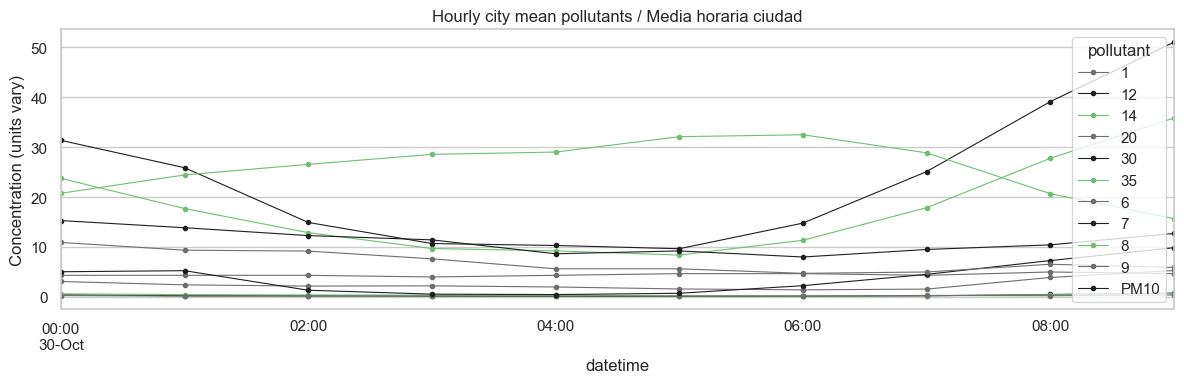

c:\Users\LAP-MPC\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
c:\Users\LAP-MPC\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
c:\Users\LAP-MPC\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
c:\Users\LAP-MPC\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
c:\Users\LAP-MPC\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py

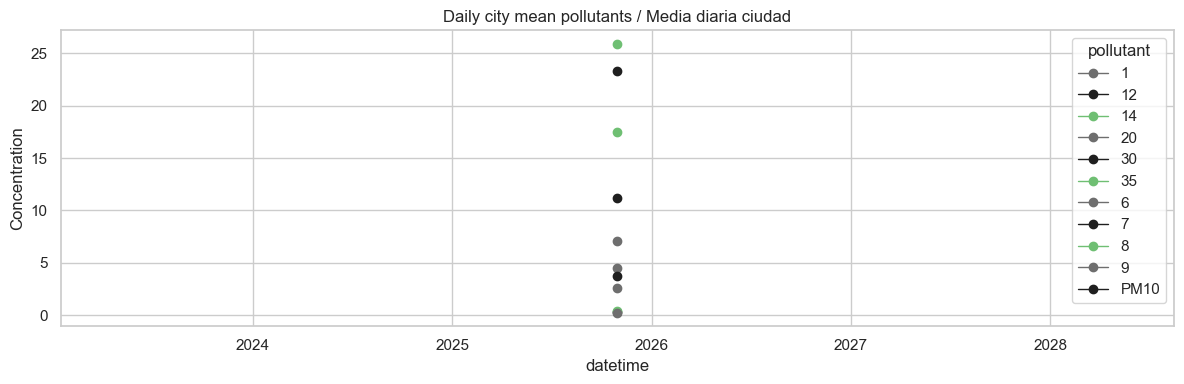

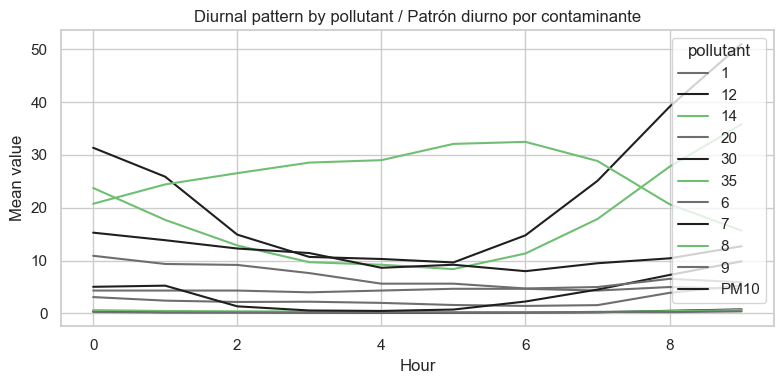


Hourly city correlation (Pearson) / Correlación horaria ciudad (Pearson):
pollutant      1     12     14     20     30     35      6      7      8  \
pollutant                                                                  
1          1.000  0.471 -0.256  0.390  0.446 -0.006  0.288  0.491  0.456   
12         0.471  1.000 -0.914  0.895  0.961  0.754  0.876  0.989  0.997   
14        -0.256 -0.914  1.000 -0.949 -0.936 -0.928 -0.744 -0.866 -0.933   
20         0.390  0.895 -0.949  1.000  0.965  0.843  0.748  0.843  0.915   
30         0.446  0.961 -0.936  0.965  1.000  0.810  0.866  0.921  0.975   
35        -0.006  0.754 -0.928  0.843  0.810  1.000  0.610  0.695  0.782   
6          0.288  0.876 -0.744  0.748  0.866  0.610  1.000  0.848  0.882   
7          0.491  0.989 -0.866  0.843  0.921  0.695  0.848  1.000  0.974   
8          0.456  0.997 -0.933  0.915  0.975  0.782  0.882  0.974  1.000   
9         -0.404  0.098 -0.390  0.162  0.112  0.565 -0.087  0.058  0.127   
PM10      -0.

In [ ]:
# Real-time AIR EDA + relations to GEI, PST, CEEE (air is realtime DF) / EDA AIR realtime + relación con GEI,PST,CEEE
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
sns.set(style="whitegrid")

# Colors
C_GREY, C_DARK, C_LTGREEN, C_ALERT = "#6E6E6E", "#1F1F1F", "#6FBF73", "#D9534F"

# --- 0. reshape air to long hourly table / pasar air a formato largo horario ---
air_long = air.copy()
hours = [f"h{str(i).zfill(2)}" for i in range(1,25)]
vals  = [f"v{str(i).zfill(2)}" for i in range(1,25)]
id_cols = ["provincia","municipio","estacion","magnitud","punto_muestreo","ano","mes","dia"]
air_vals = air_long.melt(id_vars=id_cols, value_vars=hours, var_name="hour", value_name="value")
air_vals_v = air_long.melt(id_vars=id_cols, value_vars=vals, var_name="vhour", value_name="vcode")
air_vals_v["hour"] = air_vals_v["vhour"].str.replace("v","h")
air_long = air_vals.merge(air_vals_v[id_cols+["hour","vcode"]], on=id_cols+["hour"], how="left")
air_long["value"] = pd.to_numeric(air_long["value"].replace(["","-","NA","NaN",None], np.nan), errors="coerce")
# keep validated or substituted only
air_long = air_long[air_long["vcode"].isin(["V","S"])].copy()
# standard columns
air_long["year"] = air_long["ano"].astype(int)
air_long["month"] = air_long["mes"].astype(int)
air_long["day"] = air_long["dia"].astype(int)
air_long["datetime"] = pd.to_datetime(air_long[["year","month","day"]]) + \
                       pd.to_timedelta(air_long["hour"].str.extract(r"h(\d{2})").astype(int)[0]-1, unit="h")
# map pollutant names
polls = {"09":"PM2.5","10":"PM10","08":"NO2"}
air_long["pollutant"] = air_long["magnitud"].map(polls).fillna(air_long["magnitud"])

# --- A. PURE REAL-TIME EDA (hourly / daily / diurnal) / EDA REALTIME PURA ---
# hourly city-wide mean by pollutant
hourly_city = air_long.groupby(["datetime","pollutant"])["value"].mean().unstack().sort_index()
hourly_city.plot(figsize=(12,4), color=[C_GREY,C_DARK,C_LTGREEN], marker=".", linewidth=0.8, title="Hourly city mean pollutants / Media horaria ciudad")
plt.ylabel("Concentration (units vary)"); plt.tight_layout(); plt.show()

# daily city-wide mean (smoother)
daily_city = hourly_city.resample("D").mean()
daily_city.plot(figsize=(12,4), color=[C_GREY,C_DARK,C_LTGREEN], marker="o", linewidth=1, title="Daily city mean pollutants / Media diaria ciudad")
plt.ylabel("Concentration"); plt.tight_layout(); plt.show()

# diurnal pattern (hour of day) per pollutant
air_long["hour_of_day"] = air_long["datetime"].dt.hour
diurnal = air_long.groupby(["hour_of_day","pollutant"])["value"].mean().unstack()
plt.figure(figsize=(8,4)); diurnal.plot(ax=plt.gca(), color=[C_GREY,C_DARK,C_LTGREEN])
plt.title("Diurnal pattern by pollutant / Patrón diurno por contaminante"); plt.xlabel("Hour"); plt.ylabel("Mean value"); plt.tight_layout(); plt.show()

# correlation matrix on hourly city means (requires enough overlap)
print("\nHourly city correlation (Pearson) / Correlación horaria ciudad (Pearson):")
print(hourly_city.corr().round(3))

# cross-correlation (lags) between PM10 and NO2 (example)
def cross_corr(s1, s2, maxlag=14):
    lags = range(-maxlag, maxlag+1)
    return [s1.corr(s2.shift(l)) for l in lags], lags
if "PM10" in hourly_city.columns and "NO2" in hourly_city.columns:
    series1 = hourly_city["PM10"].dropna().resample("H").mean()
    series2 = hourly_city["NO2"].dropna().resample("H").mean()
    cc_vals, lags = cross_corr(series1, series2, maxlag=48)
    plt.figure(figsize=(8,3)); plt.stem(lags, cc_vals, basefmt=" ", use_line_collection=True)
    plt.axvline(0, color=C_DARK, lw=0.8); plt.title("Cross-corr PM10 vs NO2 (hours lag) / Cross-corr PM10 vs NO2 (h)"); plt.xlabel("lag (hours)"); plt.ylabel("corr"); plt.tight_layout(); plt.show()

# --- B. RELATE REAL-TIME AIR TO ANNUAL EMISSION DATA (pragmatic alignment by year) / RELACIONAR AIR REALTIME con GEI/PST/CEEE ---
# prepare annual GEI and PST (if present) and map to each real-time record by year
if 'df_gei' in globals():
    gei_year = df_gei.groupby("gei_yr")["gei_co2_eq_t"].sum()
else:
    gei_year = pd.Series(dtype=float)
if 'df_pst' in globals():
    pst_year = df_pst.groupby("year")["tons_pst"].sum()
else:
    pst_year = pd.Series(dtype=float)

# merge annual emissions as year-level columns into daily_city (or hourly if preferred)
daily_city = daily_city.reset_index()
daily_city["year"] = daily_city["datetime"].dt.year
daily_city["GEI_total"] = daily_city["year"].map(gei_year).astype(float)
daily_city["PST_total"] = daily_city["year"].map(pst_year).astype(float)

# now test relations at daily resolution using year-mapped GEI/PST (levels + changes)
print("\nRelations using year-aligned emissions (each day carries that year's annual GEI/PST):")
pairs = [("PM10","GEI_total"), ("PM10","PST_total"), ("PM2.5","PST_total"), ("NO2","GEI_total")]
for a,b in pairs:
    if a in daily_city.columns and daily_city[b].notna().any():
        sub = daily_city[[a,b]].dropna()
        if len(sub)>10:
            r,p = stats.pearsonr(sub[a], sub[b])
            print(f"{a} vs {b}: r={r:.3f}, p={p:.3g}, n={len(sub)}")
        else:
            print(f"{a} vs {b}: insufficient data / datos insuficientes")
    else:
        print(f"{a} vs {b}: missing columns / faltan columnas")

# Δ-day co-movement (to reduce level bias)
d = daily_city.set_index("datetime").diff().dropna()
for a,b in pairs:
    if a in d.columns and b in d.columns:
        sub = d[[a,b]].dropna()
        if len(sub)>10:
            r,p = stats.pearsonr(sub[a], sub[b])
            print(f"Δ {a} vs Δ {b}: r={r:.3f}, p={p:.3g}, n={len(sub)}")

# --- C. LINK REAL-TIME AIR TO BUILDINGS (CEEE) SPATIALLY IF STATION->POSTAL MAP PROVIDED / ENLAZAR CON CEEE SI EXISTE MAPA ESTACIÓN->CÓDIGO POSTAL ---
# if you have a mapping DataFrame station_postal_map with columns ['estacion','postal_code'] uncomment and set it
# station_postal_map = pd.DataFrame(...)  # provide this if available
if 'station_postal_map' in globals():
    # aggregate station-level daily means, join to postal code building averages
    station_daily = air_long.groupby(["estacion","pollutant", pd.Grouper(key="datetime", freq="D")])["value"].mean().unstack().reset_index().rename(columns={"datetime":"date"})
    # building aggregates by postal
    b_agg = df_ceee.groupby("e_postal_code")[["nonren_heating_kwh_m2_a","final_heating_kwh_m2_a","e_heating_demand_kwh_m2_a"]].mean().rename_axis("e_postal_code").reset_index()
    m = station_postal_map.merge(b_agg, left_on="postal_code", right_on="e_postal_code", how="left")
    station_merged = station_daily.merge(m, left_on="estacion", right_on="estacion", how="left")
    # example test: station PM10 vs local nonren intensity (dropna)
    st = station_merged.dropna(subset=["PM10","nonren_heating_kwh_m2_a"])
    if len(st)>20:
        r,p = stats.pearsonr(st["PM10"], st["nonren_heating_kwh_m2_a"])
        print(f"\nSpatial test: station PM10 vs local mean nonrenewable intensity: r={r:.3f}, p={p:.3g}, n={len(st)}")
    else:
        print("\nStation-postal merge produced too few matched rows for a robust test / pocos datos tras merge")
else:
    print("\nNo station_postal_map provided; spatial link to CEEE skipped / sin station_postal_map, se omite enlace espacial")

# --- D. SHORT INTERPRETATION / INTERPRETACIÓN BREVE ---
print("\nInterpretation guidance / Guía de interpretación:")
print("- A: real-time correlations and diurnal/lag patterns show immediate air quality dynamics independent of annual totals.")
print("- B: mapping annual GEI/PST to realtime records (by year) is pragmatic for level tests, but Δ-day/Δ-year co-movement reduces spurious associations.")
print("- C: spatial linking (station→postal) is preferred to test building-level effects; provide station_postal_map to enable it.")
